<a href="https://colab.research.google.com/github/Minxing-Zheng/CMU_10701_GroupProject/blob/main/10701_ConformalPrediction_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Minxing-Zheng/CMU_10701_GroupProject.git
%cd CMU_10701_GroupProject


Cloning into 'CMU_10701_GroupProject'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 34 (delta 6), reused 32 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 27.69 MiB | 18.32 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/CMU_10701_GroupProject


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------
# Import your modules
# ----------------------------------------------------------
from models.mlp_scorer import MLPScorer
from utils.yahoo_loader import predict_and_summarize
from utils.split_utils import split_query_dict, make_query_dict
from utils.fdp_eval import compute_fdp, find_lambda_hat



In [ ]:
# ==========================================================
# 2. Load checkpoint
# ==========================================================

torch.serialization.add_safe_globals([StandardScaler])

device = torch.device("cpu")

checkpoint = torch.load(
    "saved_lambdarank_model.pt",
    map_location=device,
    weights_only=False
)

loaded_model = MLPScorer(
    in_dim=checkpoint["n_features"],
    hidden=checkpoint["args"]["hidden"],
    dropout=checkpoint["args"]["dropout"]
)
loaded_model.load_state_dict(checkpoint["model_state_dict"])
loaded_model.to(device)
loaded_model.eval()

scaler = checkpoint["scaler"]   # this now loads correctly
n_features = checkpoint["n_features"]

print("Model loaded.")


Model loaded.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:

# ==========================================================
# 3. Predict on small Yahoo test file
# ==========================================================

# ----------------------------------------------------------
# Run prediction
# ----------------------------------------------------------
DATA_DIR = "Learning to Rank Challenge/ltrc_yahoo/"
df_summary = predict_and_summarize(model=loaded_model, data_dir=DATA_DIR, test_file_name ='set1.test.small.txt', device= device, Fdim = n_features, scaler = scaler)
df_summary["pred_score"] = 1 / (1 + np.exp(-df_summary["pred_score"])) ### here the raw predicted scores are scaled via sigmoid function to [0,1] ###
df_summary.head() # we need qid, docid, true_label, pred_score columns in the predicted df.

,qid,doc_id,label,pred_score
0,22939,0,0,0.622459
1,22939,1,1,0.608884
2,22939,2,1,0.684478
3,22939,3,0,0.649766
4,22939,4,0,0.659576


In [ ]:

# ==========================================================
# 4. Convert to query_dict, split train/calib
# the dict form is { qid1: [(docid1, label1, pred_score1), (docid2, label2, pred_score2), ...],
#                  qid2: [...], ... }
# ==========================================================
query_dict = (
    df_summary.groupby("qid")[["doc_id","label","pred_score"]]
    .apply(lambda g: list(zip(g["doc_id"],g["label"],g["pred_score"])))
    .to_dict()
)
calib_dict_full, test_dict_full = split_query_dict(query_dict)
print(f"Number of calibration queries: {len(calib_dict_full)}")
print(f"Number of test queries: {len(test_dict_full)}")

Number of calibration queries: 493
Number of test queries: 494


In [ ]:
# ==========================================================
# 5. Compute FDP + λ̂ search
# ==========================================================


#### set up parameters ####
alpha = 0.3
delta = 0.1
lambda_step = 0.001 # the step size when searching for lambda_hat on calibration set
high_quality_threshold = 3 #### define any label >=high_quality_threshold as high-quality ####

### a toy example to compute FDP at a fixed lambda value ###
lambda_value = 0.50  # example threshold
fdp_per_qid, summary = compute_fdp(calib_dict_full, lambda_value,label_threshold=high_quality_threshold)
print(f"λ = {lambda_value:.3f}")
print(f"Empirical FDR: {summary['mean_fdp']:.4f}")


λ = 0.500
Empirical FDR: 0.8879


In [ ]:

### repeat experiment n_exp times ###
mean_fdr_list = []
mean_size_list = []
mean_true_list = []
lambda_list = []
success = []
n_exp = 100
for i in range(n_exp):
    cal, test = split_query_dict(query_dict, random_state=42+i)
    lam = find_lambda_hat(cal, delta, alpha, lambda_step)
    lambda_list.append(lam)

    _, summary = compute_fdp(test, lam, high_quality_threshold)
    fdr = summary["mean_fdp"]

    mean_fdr_list.append(fdr)
    mean_size_list.append(summary["mean_selected"])
    mean_true_list.append(summary["mean_true"])
    success.append(fdr <= alpha)

    if (i + 1) % 20 == 0 or i == 0:
        print(f"[{i+1:03d}/{n_exp}]  λ̂={lam:.3f}   meanFDR={fdr:.3f}")


[001/100]  λ̂=0.722   meanFDR=0.260
[020/100]  λ̂=0.722   meanFDR=0.238
[040/100]  λ̂=0.723   meanFDR=0.221
[060/100]  λ̂=0.722   meanFDR=0.251
[080/100]  λ̂=0.721   meanFDR=0.276
[100/100]  λ̂=0.723   meanFDR=0.207


In [ ]:
# ==========================================================
# 6. Final Summary
# ==========================================================
p_hat = np.mean(success)
print("\n================== Conformal FDR Summary ==================")
print(f"α (target FDR):              {alpha}")
print(f"δ (tolerance):               {delta}")
print(f"Target:                      P(FDR ≤ α) ≥ 1-δ = {1-delta:.3f}")
print(f"Empirical:                   P̂ = {p_hat:.3f}")
print(f"Mean FDR:                    {np.mean(mean_fdr_list):.3f} ± {np.std(mean_fdr_list):.3f}")
print(f"Mean set size:               {np.mean(mean_size_list):.2f} ± {np.std(mean_size_list):.2f}")
print("============================================================")




================== Conformal FDR Summary ==================
α (target FDR):              0.3
δ (tolerance):               0.1
Target:                      P(FDR ≤ α) ≥ 1-δ = 0.900
Empirical:                   P̂ = 0.980
Mean FDR:                    0.245 ± 0.023
Mean set size:               2.31 ± 0.24


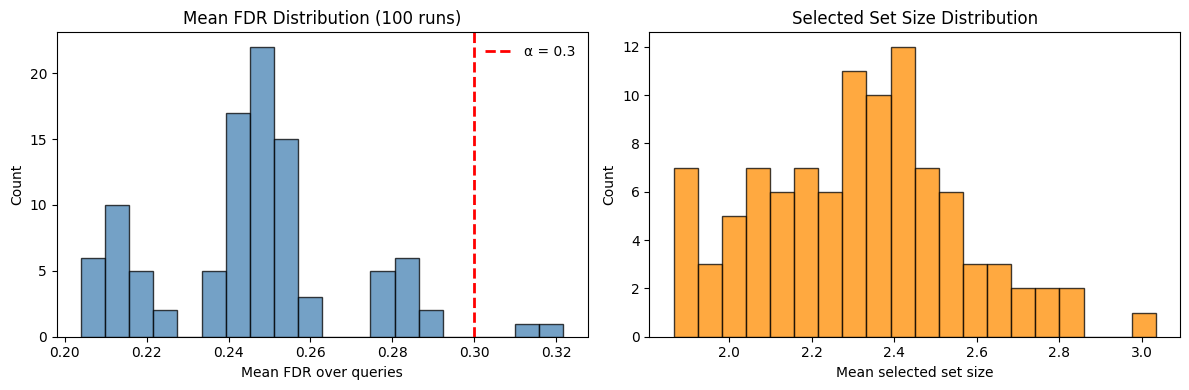

In [ ]:



# -------------------------------------------------------------
# 7. Plots — Mean FDR and Set Size Distributions
# -------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- (a) Mean FDR Distribution ---
axes[0].hist(
    mean_fdr_list,
    bins=20,
    color="steelblue",
    alpha=0.75,
    edgecolor="black"
)
axes[0].axvline(alpha, color="red", linestyle="--", linewidth=2, label=f"α = {alpha}")
axes[0].set_xlabel("Mean FDR over queries")
axes[0].set_ylabel("Count")
axes[0].set_title(f"Mean FDR Distribution ({n_exp} runs)")
axes[0].legend(frameon=False)

# --- (b) Selected Set Size Distribution ---
axes[1].hist(
    mean_size_list,
    bins=20,
    color="darkorange",
    alpha=0.75,
    edgecolor="black"
)
axes[1].set_xlabel("Mean selected set size")
axes[1].set_ylabel("Count")
axes[1].set_title("Selected Set Size Distribution")

plt.tight_layout()
plt.show()
